In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from w207_util import *

random.seed(1234)   
np.random.seed(1234)


2022-07-12 22:27:32.089160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [12]:
def train_model(train_dataset, validate_dataset, x_train,
                save_to, epoch = 2, num_of_conv_layer=1, 
                conv_layer_1_filters=32, conv_layer_2_filters=64, conv_layer_3_filters=128,
                conv_layer_4_filters=256, conv_layer_5_filters=512,
                num_of_dense_layer=0, 
                dense_layer_1_unit=1024, dense_layer_2_unit=512, dense_layer_3_unit=256,
                dense_layer_4_unit=128, dense_layer_5_unit=64,
                patience=10, epoch_denominator=10.,
                isConstantLearningRate=False, learningRate=0.001):
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    print("epoch:",epoch,"; num_of_conv_layer:",num_of_conv_layer)
    print("conv_layer_1_filters:",conv_layer_1_filters,"; conv_layer_2_filters:",conv_layer_2_filters)
    print("conv_layer_3_filters:",conv_layer_3_filters,"; conv_layer_4_filters:",conv_layer_4_filters)
    print("conv_layer_5_filters:",conv_layer_5_filters)
    print("num_of_dense_layer:",num_of_dense_layer)
    print("dense_layer_1_unit:",dense_layer_1_unit,"; dense_layer_2_unit:",dense_layer_2_unit)
    print("dense_layer_3_unit:",dense_layer_3_unit,"; dense_layer_4_unit:",dense_layer_4_unit)
    print("dense_layer_5_unit:",dense_layer_5_unit)
    print("patience:",patience,"; epoch_denominator:",epoch_denominator)
    print("isConstantLearningRate:",isConstantLearningRate,"; learningRate:",learningRate)          
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential()
        
        model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_1_filters,                
            kernel_size=3,
            strides=1,
            padding='same',
            data_format='channels_last',
            name='conv_1',
            activation='relu'))
        
        model.add(tf.keras.layers.MaxPool1D(
            pool_size=2,
            name='pool_1'))
        
        if (num_of_conv_layer >= 2):
            # add second convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_2_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_2',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_2')
            )
            
        if (num_of_conv_layer >= 3):
            # add 3rd convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_3_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_3',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_3')
            )
            
        if (num_of_conv_layer >= 4):
            # add 4th convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_4_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_4',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_4')
            )   
            
        if (num_of_conv_layer >= 5):
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_5_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_5',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_5')
            )                

        model.add(Flatten()) 
        
        # Add Dense layer
        if (num_of_dense_layer >= 1):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_1_unit,
                name='fc_1', 
                activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 2):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_2_unit,
            name='fc_2', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 3):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_3_unit,
            name='fc_3', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 4):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_4_unit,
            name='fc_4', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 5):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_5_unit,
            name='fc_5', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
            

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, x_train.shape[1], 1))
        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=learningRate)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
            
        if isConstantLearningRate:  
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
        else:  
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

        
    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])
        
    return model,history


In [3]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3446)


In [22]:

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)

print(init_df.head())

features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

init_df.head()
print(init_df.columns)


y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)



scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validate = scaler.transform(X_validate)

# 95% of variance is retained
# pca = PCA(0.95)
pca = PCA(0.70)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_validate = pca.transform(X_validate)
X_test = pca.transform(X_test)



X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset


   lag1_mean_0  lag1_mean_1  lag1_mean_2  lag1_mean_3  lag1_mean_4  \
0     0.165685    -0.852441     0.305529     0.069311    -0.820157   
1    -1.280358    -3.529726     1.199699    -1.149790     0.738967   
2     1.830922    -1.242559     0.019590    -0.955141     4.069830   
3     0.726474    -0.013534     3.577241    -1.806816     0.604612   
4    -0.338823     0.202537    -0.062122    -1.623981    -0.346947   

   lag1_mean_5  lag1_mean_6  lag1_mean_7  lag1_mean_8  lag1_mean_9  ...  \
0     0.671192    -0.889876     0.491933    -0.284130     0.031775  ...   
1    -4.185435    -1.864589    -0.710929     2.279327     0.201870  ...   
2    -8.934466     0.863457     1.437240    -1.496749     0.993456  ...   
3    -0.489957     0.936905    -2.145070    -0.171676    -0.505224  ...   
4    -0.717592    -1.123954    -1.435684     0.115600    -1.780939  ...   

   freq_669_12  freq_679_12  freq_689_12  freq_699_12  freq_709_12  \
0     0.010112     0.002127     0.010123     0.004699     

<BatchDataset shapes: ((None, 360, 1), (None, 4)), types: (tf.float64, tf.uint8)>

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 5
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; conv_layer_4_filters: 256
conv_layer_5_filters: 512
num_of_dense_layer: 2
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; dense_layer_4_unit: 128
dense_layer_5_unit: 64
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 360, 32)           128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 180, 32)           0         
_________________________________________________________________
conv_2 (Conv

2022-07-12 23:01:26.566894: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 360
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
750/752 [============================>.] - ETA: 0s - loss: 1.3395 - accuracy: 0.3090 - precision: 0.5094 - recall: 0.0407

2022-07-12 23:01:39.211798: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 360
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 16s 16ms/step - loss: 1.3392 - accuracy: 0.3092 - precision: 0.5100 - recall: 0.0409 - val_loss: 1.1444 - val_accuracy: 0.4334 - val_precision: 0.7779 - val_recall: 0.1416
Epoch 2/40
752/752 [==============================] - 10s 13ms/step - loss: 1.0951 - accuracy: 0.4792 - precision: 0.7211 - recall: 0.2310 - val_loss: 0.9436 - val_accuracy: 0.5811 - val_precision: 0.7800 - val_recall: 0.3508
Epoch 3/40
752/752 [==============================] - 10s 13ms/step - loss: 0.9110 - accuracy: 0.5906 - precision: 0.7635 - recall: 0.4095 - val_loss: 0.8610 - val_accuracy: 0.6255 - val_precision: 0.7803 - val_recall: 0.4711
Epoch 4/40
752/752 [==============================] - 10s 13ms/step - loss: 0.7842 - accuracy: 0.6663 - precision: 0.7944 - recall: 0.5197 - val_loss: 0.8396 - val_accuracy: 0.6466 - val_precision: 0.7427 - val_recall: 0.5398
Epoch 5/40
752/752 [==============================] - 10s 13ms/step - loss: 0.6695 - accuracy: 0.7166 - pre

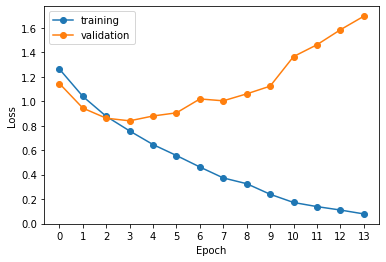

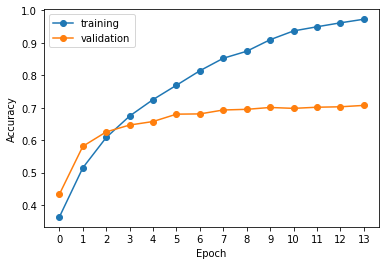

 10/251 [>.............................] - ETA: 1s - loss: 1.4012 - accuracy: 0.7156 - precision: 0.7229 - recall: 0.7094 

2022-07-12 23:03:55.094551: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 360
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 7ms/step - loss: 1.6248 - accuracy: 0.7097 - precision: 0.7156 - recall: 0.7064

Test Acc. 70.97%


In [24]:
# model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
# #                             num_of_conv_layer=3, num_of_dense_layer=3
#                            )

model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=5, num_of_dense_layer=2)


history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))